In [1]:
!pip install piq

In [2]:
import os
import cv2
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim
from piq import LPIPS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
root = '/kaggle/working/'
full_train_set = datasets.CIFAR100(root, train=True,  download=True)
full_test_set  = datasets.CIFAR100(root, train=False, download=True)

g = torch.Generator().manual_seed(42)

train_set, val_set = random_split(full_train_set, [40_000, 10_000], generator=g)

test_indices = torch.randperm(len(full_test_set), generator=g)[:10_000]
test_set = Subset(full_test_set, test_indices)

100%|██████████| 169M/169M [00:04<00:00, 34.7MB/s] 


In [22]:
class RandomWhiteOut:
    def __init__(self, scale=(0.02, 0.05), ratio=(0.3, 3.3)):
        self.scale = scale
        self.ratio = ratio

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        w, h = img.size
        area = h * w
        img_np = np.array(img, copy=True)
        mask_np = np.zeros((h, w), dtype=np.uint8)

        for _ in range(10):
            target_area = random.uniform(*self.scale) * area
            aspect_ratio = random.uniform(*self.ratio)

            erase_w = int(round((target_area * aspect_ratio) ** 0.5))
            erase_h = int(round((target_area / aspect_ratio) ** 0.5))

            if erase_w <= w and erase_h <= h:
                x1 = random.randint(0, w - erase_w)
                y1 = random.randint(0, h - erase_h)

                img_np[y1:y1+erase_h, x1:x1+erase_w, :] = 255
                mask_np[y1:y1+erase_h, x1:x1+erase_w] = 1

                break

        noisy_tensor = transforms.ToTensor()(img_np)
        mask_tensor = torch.from_numpy(mask_np)[None].float()
        return noisy_tensor, mask_tensor

In [23]:
class DAEDataset(Dataset):
    def __init__(self, dataset, clean_tf=None, noisy_tf=None):
        self.dataset = dataset
        self.clean_tf = clean_tf or transforms.ToTensor()
        self.noisy_tf = noisy_tf or RandomWhiteOut()
        super().__init__()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        clean_img = self.clean_tf(img)
        noisy_img, mask = self.noisy_tf(img)
        return noisy_img, clean_img, mask

In [25]:
train_dataset = DAEDataset(train_set)
val_dataset = DAEDataset(val_set)
test_dataset = DAEDataset(test_set)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [79]:
class EncoderResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
        )
        self.relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        return self.relu(x + self.block(x))

In [80]:
class EncoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1,
                 has_batch_norm=True, has_activation=True, has_resblock=True):
        super().__init__()
        layers = []
        layers = [nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=not has_batch_norm
        )]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if has_activation:
            layers.append(nn.LeakyReLU(0.1, inplace=True))
        if has_resblock:
            layers.append(EncoderResBlock(out_channels))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [81]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__() # (N, 3, 32, 32)
        self.layer1 = EncoderLayer(3, 16) # (N, 16, 16, 16)
        self.layer2 = EncoderLayer(16, 32) # (N, 32, 8, 8)
        self.layer3 = EncoderLayer(32, 64) # (N, 64, 4, 4)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        ) # (N, 128, 4, 4)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return self.bottleneck(out)

In [82]:
class DecoderResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
        )
        self.relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):
        return self.relu(x + self.block(x))

In [83]:
class DecoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1,
                 has_batch_norm=True, has_activation=True, has_resblock=True):
        super().__init__()
        layers = [nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride, padding, output_padding=output_padding, bias=not has_batch_norm
        )]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if has_activation:
            layers.append(nn.LeakyReLU(0.1, inplace=True))
        if has_resblock:
            layers.append(DecoderResBlock(out_channels))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [84]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__() # (N, 128, 4, 4)
        self.pre = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        ) # (N, 64, 4, 4)
        self.layer1 = DecoderLayer(64, 32) # (N, 64, 4, 4)
        self.layer2 = DecoderLayer(32, 16) # (N, 16, 16, 16)
        self.layer3 = DecoderLayer(16, 3, has_batch_norm=False, 
                                   has_activation=False, has_resblock=False) # (N, 3, 32, 32)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pre(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return self.sigmoid(out)

In [102]:
class DAEModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [103]:
model = Encoder()
dummy = torch.randn(4, 3, 32, 32)        # (batch, C, H, W)
out   = model(dummy)
print(out.shape)  

torch.Size([4, 128, 4, 4])


In [104]:
model = Decoder()
dummy = torch.randn(4, 128, 4, 4)        # (batch, C, H, W)
out   = model(dummy)
print(out.shape)  

torch.Size([4, 3, 32, 32])


In [105]:
model = DAEModel()
dummy = torch.randn(4, 3, 32, 32)        # (batch, C, H, W)
out   = model(dummy)
print(out.shape)  

torch.Size([4, 3, 32, 32])


In [107]:
def weighted_pixel_loss(recon, clean, mask, p=1):
    diff = (recon - clean).abs() if p == 1 else (recon - clean) ** 2

    patch_loss = (diff * mask).sum() / mask.sum().clamp(min=1.0)
    bg_loss    = (diff * (1 - mask)).mean()

    total_pixels = mask.size(0) * mask.size(2) * mask.size(3)
    patch_pixels = mask.sum()
    frac = patch_pixels / total_pixels
    alpha_patch = (1 - frac) / frac.clamp(min=1e-6)
    alpha_bg = 1.0

    return alpha_patch * patch_loss + alpha_bg * bg_loss

In [108]:
lpips_fn = LPIPS(reduction="mean").to(device)
def perceptual_loss(recon, clean, w_lpips=0.2):
    recon = recon * 2 - 1
    clean = clean * 2 - 1
    return w_lpips * lpips_fn(recon, clean)

In [109]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = DAEModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

saved_model_state_path = '/kaggle/working/model_state_dict.pth'

best_val_loss = float('inf')
patience = 4
num_consecutive_bad_epochs = 0

for epoch in range(num_epochs):
    train_total = 0
    train_loss = 0.0
    
    model.train()
    
    for noisy_imgs, clean_imgs, masks in train_loader:
        noisy_imgs, clean_imgs, masks = noisy_imgs.to(device), clean_imgs.to(device), masks.to(device)
        recon_imgs = model(noisy_imgs)

        optimizer.zero_grad()
        loss = weighted_pixel_loss(recon_imgs, clean_imgs, masks)
        loss += perceptual_loss(recon_imgs, clean_imgs)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * noisy_imgs.size(0)
        train_total += noisy_imgs.size(0)
        
    model.eval()

    val_loss = 0.0
    val_total = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs, masks in val_loader:
            noisy_imgs, clean_imgs, masks = noisy_imgs.to(device), clean_imgs.to(device), masks.to(device)
            recon_imgs = model(noisy_imgs)
    
            loss = weighted_pixel_loss(recon_imgs, clean_imgs, masks)
            loss += perceptual_loss(recon_imgs, clean_imgs)
            
            val_loss += loss.item() * noisy_imgs.size(0)
            val_total += noisy_imgs.size(0)

    avg_train_loss = train_loss / train_total
    avg_val_loss = val_loss / val_total
    
    if avg_val_loss < best_val_loss:
        torch.save(model.state_dict(), saved_model_state_path)
        best_val_loss = avg_val_loss
        num_consecutive_bad_epochs = 0
    else:
        num_consecutive_bad_epochs += 1
        if (num_consecutive_bad_epochs >= patience):
            print("Early stopping")
            break
    
    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {avg_train_loss:.6f} — "
          f"Val Loss: {avg_val_loss:.6f}") 

Epoch 1/25 — Train Loss: 10.452493 — Val Loss: 8.775200
Epoch 2/25 — Train Loss: 8.518763 — Val Loss: 8.012942
Epoch 3/25 — Train Loss: 8.010299 — Val Loss: 8.275012
Epoch 4/25 — Train Loss: 7.745556 — Val Loss: 7.782403
Epoch 5/25 — Train Loss: 7.594676 — Val Loss: 7.762521
Epoch 6/25 — Train Loss: 7.504984 — Val Loss: 8.005562


KeyboardInterrupt: 

In [47]:
print(recon_imgs.min().item(), recon_imgs.max().item())   # should be ~0‑1
recon_imgs.shape, masks.shape

0.021832585334777832 0.999786913394928


(torch.Size([64, 3, 32, 32]), torch.Size([64, 1, 32, 32]))

In [50]:
weighted_pixel_loss(recon_imgs, clean_imgs, masks, p=1)

tensor(0.4254, device='cuda:0')


tensor(0.2824, device='cuda:0', grad_fn=<AddBackward0>)

In [110]:
saved_model_state_path = '/kaggle/working/model_state_dict.pth'
model = DAEModel().to(device)
model.load_state_dict(torch.load(saved_model_state_path))

model.eval()

test_loss = 0.0
test_total = 0

with torch.no_grad():
    for noisy_imgs, clean_imgs, masks in test_loader:
        noisy_imgs, clean_imgs, masks = noisy_imgs.to(device), clean_imgs.to(device), masks.to(device)
        
        recon_imgs = model(noisy_imgs)
        loss = weighted_pixel_loss(recon_imgs, clean_imgs, masks)
        loss += perceptual_loss(recon_imgs, clean_imgs)

        test_loss += loss.item() * noisy_imgs.size(0)
        test_total += noisy_imgs.size(0)

avg_test_loss = test_loss / test_total
print(f"Test Loss: {avg_test_loss:.6f}")

Test Loss: 7.812522


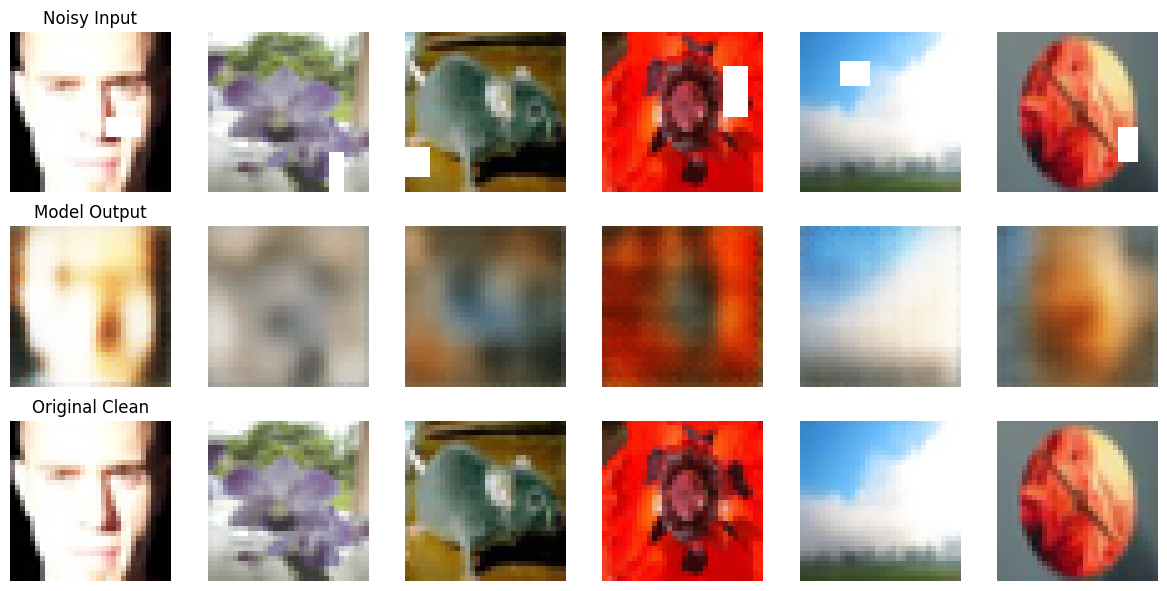

In [111]:
import matplotlib.pyplot as plt
import torch

model.eval()

with torch.no_grad():
    for noisy_imgs, clean_imgs, _ in test_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        recon_imgs = model(noisy_imgs)
        break

# Convert tensors to numpy for plotting
noisy_imgs = noisy_imgs.detach().cpu().numpy()
recon_imgs = recon_imgs.detach().cpu().numpy()
clean_imgs = clean_imgs.detach().cpu().numpy()

num_samples = 6
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))

for i in range(num_samples):
    axes[0, i].imshow(np.transpose(noisy_imgs[i], (1, 2, 0)))
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Noisy Input")

    axes[1, i].imshow(np.transpose(recon_imgs[i], (1, 2, 0)))
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Model Output")

    axes[2, i].imshow(np.transpose(clean_imgs[i], (1, 2, 0)))
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_title("Original Clean")

plt.tight_layout()
plt.show()